Consider SDE
$$
dX_t = \sum_{k=1}^{m} B^{k}X_{t}dW^{k}_{t},\quad X_{t}\in \mathbb{R}^{n}, W_{t}\in\mathbb{R}^{m}, B^{k} \in \mathbb{R}^{n\times n}
$$
$$
B^{i}B^{j} \neq B^{j}B^{i}, \quad i\neq j 
$$
where
$$
B^{k} = \begin{bmatrix} \sigma_{1,1}^{k}& & \\ &\ddots& \\ & & \sigma_{d,d}^{k} \end{bmatrix}
$$
Therefore 
$$
dX^{i}_t = X^{i}_{t} \sum_{k=1}^{m} \sigma^{k}_{i,i}dW^{k}_{t}
$$

Analytic solution
$$
X^{i}_{t} = \exp\Big\{\sum_{k=1}^{m}\sigma_{i,i}^{k}W_{t}^{k} - \frac{t}{2}\sum_{k=1}^{m}(\sigma_{i,i}^{k})^{2}\Big\}X^{i}_{0}
$$
$$
X_{t} = \exp\Big\{\sum_{k=1}^{m}B^{k}W_{t}^{k} - \frac{t}{2}\sum_{k=1}^{m}(B^{k})^{2}\Big\}X_{0}
$$

Euler approximation
$$
X^{i}_{t} = \Big(I + \sum_{k=1}^{m} \sigma^{k}_{i,i}dW^{k}_{t}\Big)X_{0}^{i}
$$
$$
X_{t} = \Big(I + \sum_{k=1}^{m} B^{k}dW^{k}_{t}\Big)X_{0}
$$

Milstein approximation
$$
X_{t}^{i} = \bigg(I + \sum_{k=1}^{m} \sigma_{i,i}^{k}dW^{k}_{t} + \frac{1}{2}\Big(\sum_{k=1}^{m} \sigma_{i,i}^{k}dW^{k}_{t}\Big)^2 - \frac{t}{2}\sum_{k=1}^{m}(\sigma_{i,i}^{k})^{2}\bigg) X_{0}^{i}
$$
$$
X_{t} = \bigg(I + \sum_{k=1}^{m}B^{k}dW^{k}_{t} + \frac{1}{2}\Big(\sum_{k=1}^{m} B^{k}dW^{k}_{t}\Big)^2 - \frac{t}{2}\sum_{k=1}^{m}(B^{k})^{2}\bigg) X_{0}
$$

Taylor expansion
$$
X^{i}_{t} = \sum_{d=0}^{\infty}\frac{1}{d!}\Big(\sum_{k=1}^{m}\sigma_{i,i}^{k}W_{t}^{k} - \frac{t}{2}\sum_{k=1}^{m}(\sigma_{i,i}^{k})^{2}\Big)^{d}X^{i}_{0}
$$
$$
X_{t} = \sum_{d=0}^{\infty}\frac{1}{d!}\Big(\sum_{k=1}^{m}B^{k}W_{t}^{k} - \frac{t}{2}\sum_{k=1}^{m}(B^{k})^{2}\Big)^{d}X_{0}
$$

Signature expansion
$$
X^{i}_t = \sum_{d = 0}^{\infty}\sum_{i_{1},\cdots,i_{d} = 1}^{n} \bigg(\int_{0\leq t_{1}\leq\cdots\leq t_{d}\leq t}dW^{i_{1}}_{t_{1}}\cdots dW^{i_{d}}_{t_{d}}\bigg)\sigma^{i_{d}}_{i,i}\cdots \sigma^{i_{1}}_{i,i} X^{i}_{0}
$$
$$
X_t = \sum_{d = 0}^{\infty}\sum_{i_{1},\cdots,i_{d} = 1}^{n} \bigg(\int_{0\leq t_{1}\leq\cdots\leq t_{d}\leq t}dW^{i_{1}}_{t_{1}}\cdots dW^{i_{d}}_{t_{d}}\bigg)B^{i_{d}}\cdots B^{i_{1}} X_{0}
$$

Ito vs Stratonovich
$$
X\circ dW = XdW + d[X,W]
$$

Consider SDE
$$
d\begin{bmatrix} X^{1}_{t} \\ X^{2}_{t} \end{bmatrix} = \begin{bmatrix} 0.5 & 0 \\ 0 & 1 \end{bmatrix}\begin{bmatrix} X^{1}_{t} \\ X^{2}_{t} \end{bmatrix}dW^{1}_{t} + \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}\begin{bmatrix} X^{1}_{t} \\ X^{2}_{t} \end{bmatrix}dW^{2}_{t}
$$

In [35]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.linalg import expm
from matplotlib import pyplot as plt
import torch
torch.set_default_dtype(torch.float64)
import signatory

In [36]:
batch = 1
dimensionBM = 2
dimension = 2
length = 100
horizon = 1
dt = horizon / length
initial = np.ones([batch,dimension])  
# diagonal
B = np.zeros([dimensionBM,dimension,dimension])
B[0,0,0] = .5
B[0,1,1] = 1
B[1,0,0] = 2
B[1,1,1] = 1

In [23]:
'Sabr'
B[0,0,1] = 2
B[0,1,1] = 1
B[1,0,1] = 2
B[1,1,1] = 0

In [46]:
expB = np.array([expm(Bi - 0.5 * Bi@Bi * dt) for Bi in B])

In [43]:
dt
state = SDEpath[:,0,:]
increment = BMpath[:,1,:]

In [44]:
dt , state , increment

(0.01, array([[1., 1.]]), array([[-0.18356835,  0.05109485]]))

In [40]:
def semi_group_euler(state,increment,dt):
    batch, dimension = state.shape
    helper = np.array([np.eye(dimension) for i in range(batch)])
    V = np.tensordot(increment,B,axes = 1) + helper
    dX = V@(state)[:,:,None]
    return dX[:,:,0]

def semi_group_milstein(state,increment,dt):
    batch, dimension = state.shape
    I = np.array([np.eye(dimension) for i in range(batch)])
    a = np.tensordot(increment,B,axes = 1)
    b = dt * np.sum(B**2,axis = 0)
    b = np.tile(b,[batch,1])
    V = I + a + 0.5*(a**2 - b)
    dX = V@(state)[:,:,None]
    return dX[:,:,0]

def semi_group_analytic(state,increment,dt):
    a = np.tensordot(increment,B,axes = [-1,0])
    a = np.sum(a,axis = (-1))
    b = 0.5 * dt * np.sum(B**2,axis = (0,1))
    return np.exp(a-b) * state

In [ ]:
def semi_group_analytic(state,increment,dt):
    expB = np.array([expm(Bi - 0.5 * Bi@Bi * dt) for Bi in B])
    return expB * state

In [11]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,timesteps):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
#         self.dimensionR = dimensionR
#         self.vectorfield = vectorfield
        self.timesteps = timesteps
        self.dt = timehorizon / timesteps
        self.time = np.arange(self.timesteps+1)*self.dt
        self.batch = 1

    def BM(self):
        BMpath_helper = np.random.normal(0,np.sqrt(self.dt),size = (1,self.timesteps,self.dimensionBM))
        BMpath = np.cumsum(BMpath_helper,axis = 1)
        self.BMpath = np.concatenate([np.zeros([self.batch,1,self.dimensionBM]),BMpath],axis = 1)
        return self.BMpath
    def SDE_solver(self, initial, BMpath, name):
        if name == 'euler':
            sg = semi_group_euler
        elif name == 'analytic':
            sg = semi_group_analytic
        elif name == 'milstein':
            sg = semi_group_milstein
        SDEpath = np.zeros(shape = [self.batch, self.timesteps+1, self.dimension])
        SDEpath[:,0,:] = initial
        for i in range(self.timesteps):
            increment = BMpath[:,i+1,:] - BMpath[:,i,:]
            SDEpath[:,i+1,:] = sg(SDEpath[:,i,:],increment,self.dt)
        return SDEpath

In [41]:
def index_to_word(channels, depth):
    index2word = signatory.all_words(channels, depth)
    return index2word
def word_to_index(channels, depth):
    word2index = {}
    for i,word in enumerate(index2word):
        word2index.update({word: i})
    return word2index
def sig_vectorfield(channels, depth):
    index2word = index_to_word(channels, depth)
    word2index = word_to_index(channels, depth)
    dim_sig = len(index2word)+1
    V = [np.zeros([dim_sig, dim_sig]) for i in range(channels)]
    for i in range(dim_sig):
        if i > 0:
            res = (i-1)%channels
            word = index2word[i-1]
            if len(word) == 1:
                V[res][i,0] = 1
            else:
                word_reduce = tuple(list(word)[:-1])
                V[res][i,word2index[word_reduce]+1] = 1
    return V
def B_aug(B,depth):
    dimension = B.shape[-1]
    Id = np.eye(dimension)
    BB = [Id]
    index2word = index_to_word(dimension, depth)
    for word in index2word:    # dp can also be used here
        M = np.eye(dimension)
        for i in word:
            M = M @ B[i,:,:]
        BB.append(M)
    return BB

def sig_stream1(path,depth):                 # Unified depth 
    path = torch.Tensor(path)
    batch, length, channels = path.shape
    length = length-1
    index2word = index_to_word(channels, depth)
    dim_sig = len(index2word)+1
    sig_path_split = [signatory.signature(path[:,i:i+2,:], depth) for i in range(length)] 
    add = sig_path_split[0]
    sig_path_stream = [add[:,None,:]]
    for i in range(len(sig_path_split)-1):
        add = signatory.signature_combine(add, sig_path_split[i+1], channels, depth)
        sig_path_stream.append(add[:,None,:])
    sig_path_stream = torch.cat(sig_path_stream,axis = 1)
    sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig-1]),sig_path_stream],axis = 1)
    sig_path_stream = torch.cat([torch.ones([batch,length+1,1]),sig_path_stream],axis = 2)
    return sig_path_stream

def sig_stream2(path,depth_max):          # growing path
    path = torch.Tensor(path)
    batch, length, channels = path.shape
    length = length-1
    index2word = index_to_word(channels, depth_max)
    dim_sig = len(index2word)+1
    sig_path_split = [signatory.signature(path[:,i:i+2,:], 1) for i in range(length)] 
    sig_path = sig_path_split[0]
    dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,1)
    helper0 = torch.zeros(size = [1,dim_0])
    sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
    sig_path_stream = [sig_path_aug[:,None,:]]
    for i in range(len(sig_path_split)-1):
        depth_now = min(i + 2,depth_max)
        depth_pre = min(i + 1,depth_max)
        dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,depth_now)
        dim_1 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,depth_pre)
        dim_2 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,1)
        helper0 = torch.zeros(size = [1,dim_0])
        helper1 = torch.zeros(size = [1,dim_1])
        helper2 = torch.zeros(size = [1,dim_2])

        sig1 = torch.cat([sig_path,helper1],axis = -1)
        sig2 = torch.cat([sig_path_split[i+1],helper2],axis = -1)
        sig_path = signatory.signature_combine(sig1, sig2, channels, depth_now)
        sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
        sig_path_stream.append(sig_path_aug[:,None,:])

    sig_path_stream = torch.cat(sig_path_stream,axis = 1)
    sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig-1]),sig_path_stream],axis = 1)
    sig_path_stream = torch.cat([torch.ones([batch,length+1,1]),sig_path_stream],axis = 2)
    return sig_path_stream

def sigBM(path):
    batch = path.shape[0]
    channels = path.shape[-1]
    diff = path[:,1,:] - path[:,0,:]
    opt = torch.zeros([batch,6])
    opt[:,0:2] = diff
    opt[:,2] = (diff[:,0]**2 - dt)/2
    opt[:,3] = (diff[:,0]*diff[:,1])/2
    opt[:,4] = (diff[:,0]*diff[:,1])/2
    opt[:,5] = (diff[:,1]**2 - dt)/2
    return opt

def sig_stream3(path,depth_max):          # growing signature only for BM 
    path = torch.Tensor(path)
    batch, length, channels = path.shape
    length = length-1
    index2word = index_to_word(channels, depth_max)
    dim_sig = len(index2word)+1
    print(dim_sig)
    sig_path_split = [sigBM(path[:,i:i+2,:]) for i in range(length)] 
    sig_path = sig_path_split[0]
    dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,2)
    helper0 = torch.zeros(size = [1,dim_0])
    sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
    sig_path_stream = [sig_path_aug[:,None,:]]
    for i in range(len(sig_path_split)-1):
        depth_now = min(2*(i+2),depth_max)
        depth_pre = min(2*(i+1),depth_max)
        dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,depth_now)
        dim_1 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,depth_pre)
        dim_2 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,2)
        helper0 = torch.zeros(size = [1,dim_0])
        helper1 = torch.zeros(size = [1,dim_1])
        helper2 = torch.zeros(size = [1,dim_2])

        sig1 = torch.cat([sig_path,helper1],axis = -1)
        sig2 = torch.cat([sig_path_split[i+1],helper2],axis = -1)
        sig_path = signatory.signature_combine(sig1, sig2, channels, depth_now)
        sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
        sig_path_stream.append(sig_path_aug[:,None,:])

    sig_path_stream = torch.cat(sig_path_stream,axis = 1)
    sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig-1]),sig_path_stream],axis = 1)
    sig_path_stream = torch.cat([torch.ones([batch,length+1,1]),sig_path_stream],axis = 2)
    return sig_path_stream

def SDEfromSig(BMpath,initial,depth):
    channels = BMpath.shape[-1]
    index2word = index_to_word(channels, depth)
    sig_path_stream = sig_stream3(BMpath,depth).numpy()
    BB = B_aug(B,depth)
    CC = np.array([M @ initial for M in BB])
    SDEpath_by_signature = np.dot(sig_path_stream,CC)
    return SDEpath_by_signature


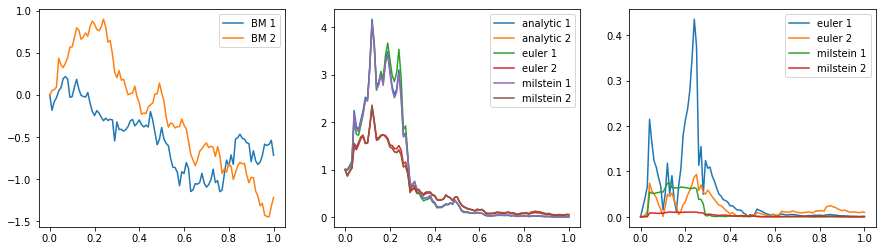

In [42]:
eq = SDE(horizon,1.0,dimension,dimensionBM,length)
time = eq.time
BMpath = eq.BM()
SDEpath = eq.SDE_solver(initial, BMpath, 'analytic')
SDEpath1 = eq.SDE_solver(initial, BMpath, 'euler')
SDEpath2 = eq.SDE_solver(initial, BMpath, 'milstein')
f,p=plt.subplots(1,3,figsize=(15,4))
p[0].plot(time,BMpath[0,:])
p[0].legend(['BM 1','BM 2'])
p[1].plot(time,SDEpath[0,:,:])
p[1].plot(time,SDEpath1[0,:,:])
p[1].plot(time,SDEpath2[0,:,:])
p[1].legend(['analytic 1','analytic 2','euler 1','euler 2', 'milstein 1','milstein 2'])
p[2].plot(time,np.abs(SDEpath[0,:,:] - SDEpath1[0,:,:]))
p[2].plot(time,np.abs(SDEpath[0,:,:] - SDEpath2[0,:,:]))
p[2].legend(['euler 1','euler 2', 'milstein 1','milstein 2'])
plt.show()       


In [7]:
SDEpath_sig = [SDEfromSig(BMpath,initial[0],i) for i in [10,15]]

2047
65535


[0.0022862937003461647, 0.005084373976800949, 0.0022914830863487445]

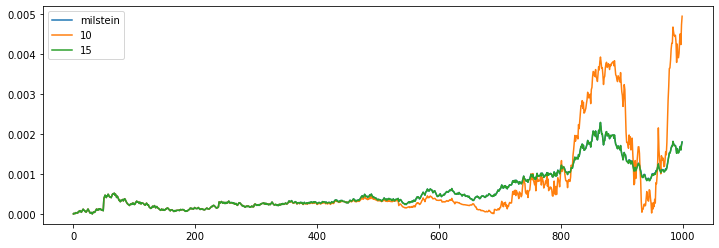

In [8]:
terminal = -1
plt.figure(figsize = (12,4))
plt.plot(np.abs(SDEpath2[0,:terminal,1] - SDEpath[0,:terminal,1]))
[plt.plot(np.abs(p[0,:terminal,1] - SDEpath[0,:terminal,1])) for p in SDEpath_sig]
plt.legend(['milstein','10','15'])
error = [np.max(np.abs(SDEpath2[0,:,1] - SDEpath[0,:,1]))]
for p in SDEpath_sig:
    error.append(np.max(np.abs(p[0,:,1] - SDEpath[0,:,1])))
error

In [46]:
# 'Sabr'
# B[0,0,1] = 2
# B[0,1,1] = 1
# B[1,0,1] = 2
# B[1,1,1] = 0

#     def reservoir(self,BMpath):
#         reservoirpath = np.zeros(shape = [self.batch, self.timesteps+1, self.dimensionR])
#         reservoirpath[:,0,0] = np.ones(self.batch)
#         for i in range(self.timesteps):
#             increment = BMpath[:,i+1,:] - BMpath[:,i,:]
#             reservoirpath[:,i+1,:] = reservoirpath[:,i,:] + self.reservoirfield(SDEpath[:,i,:],increment)
#         self.reservoirpath  = reservoirpath   
#         return reservoirpath    
    
#     def analytic_SDE(self,BMpath):
#         a = np.tensordot(BMpath,B,axes = [-1,0])
#         a = np.sum(a,axis = (-1))
#         b = 0.5 * self.time[:,None] * np.sum(B**2,axis = (0,1))
#         b = b[None,:,:]
#         return np.exp(a-b)
#     def vectorfield_linear(state,increment):
#         V = np.tensordot(B,state,axes = [2,1]).T
#         dX = V@increment[:,:,None]
#         return dX[:,:,0]
#     def euler(self,BMpath):
#         SDEpath = np.zeros(shape = [self.batch, self.timesteps+1, self.dimension])
#         SDEpath[:,0,:] = np.ones([self.batch,self.dimension])
#         for i in range(self.timesteps):
#             increment = BMpath[:,i+1,:] - BMpath[:,i,:]
#             SDEpath[:,i+1,:] = SDEpath[:,i,:] + self.vectorfield(SDEpath[:,i,:],increment)
#         return SDEpath